## Imports

In [1]:
import config
import utils.cleaning as cl
import visual.plot as vplot

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv("data/covid/france/chiffres-cles.csv", sep=",")

In [3]:
df.columns

Index(['date', 'granularite', 'maille_code', 'maille_nom', 'cas_confirmes',
       'cas_ehpad', 'cas_confirmes_ehpad', 'cas_possibles_ehpad', 'deces',
       'deces_ehpad', 'reanimation', 'hospitalises', 'gueris', 'depistes',
       'source_nom', 'source_url', 'source_archive', 'source_type'],
      dtype='object')

In [4]:
df.dtypes

date                    object
granularite             object
maille_code             object
maille_nom              object
cas_confirmes          float64
cas_ehpad              float64
cas_confirmes_ehpad    float64
cas_possibles_ehpad    float64
deces                  float64
deces_ehpad            float64
reanimation            float64
hospitalises           float64
gueris                 float64
depistes               float64
source_nom              object
source_url              object
source_archive          object
source_type             object
dtype: object

## Cleaning

In [5]:
df = cl.keep_only_france(df)
df[["date", "cas_confirmes", "source_nom"]]

,date,cas_confirmes,source_nom
13,2020-01-24,3.0,Santé publique France
14,2020-01-24,3.0,Ministère des Solidarités et de la Santé
22,2020-01-25,3.0,Santé publique France
27,2020-01-26,3.0,Santé publique France
33,2020-01-27,3.0,Santé publique France
...,...,...,...
9664,2020-05-10,NaN,OpenCOVID19-fr
9784,2020-05-11,139519.0,Ministère des Solidarités et de la Santé
9785,2020-05-11,NaN,OpenCOVID19-fr
9905,2020-05-12,140227.0,Ministère des Solidarités et de la Santé


Il y a des valeurs NAN selon les sources, on souhaite savoir s'il y a des données conflictuelles

In [6]:
cl.print_conflictual_information(df)

2020-02-07
91    11.0
92     6.0
Name: cas_confirmes, dtype: float64
2020-02-25
157    12.0
158    14.0
Name: cas_confirmes, dtype: float64
2020-02-26
170    17.0
171    18.0
Name: cas_confirmes, dtype: float64
2020-02-28
194    38.0
195    57.0
Name: cas_confirmes, dtype: float64
2020-02-29
231     73.0
232    100.0
Name: cas_confirmes, dtype: float64
2020-03-02
270    178.0
271    191.0
Name: cas_confirmes, dtype: float64
2020-03-14
1603    4499.0
1604    4500.0
Name: cas_confirmes, dtype: float64


On trouve quelques cas conflictuels. Pour résoudre le souci on prendra la valeur maximum des deux à chaque fois. On supprime donc toutes les lignes à cas confirmes NAN, et pour les cas à plusieurs sources on prendra la première.

In [7]:
cas_confirmes_df = cl.drop_NA_confirmed_cases(df)

In [8]:
evolution_par_jour = cl.keep_only_first_row_by_date(cas_confirmes_df)

In [9]:
evolution_par_jour = cas_confirmes_df.groupby("date", as_index=False).first()

On calcule la colonne de la population non malade.

In [10]:
population_FR = 67000000
evolution_par_jour["susceptible"] = population_FR - (evolution_par_jour["cas_confirmes"] +\
                                                     evolution_par_jour["deces"] + evolution_par_jour["gueris"])

## Plots

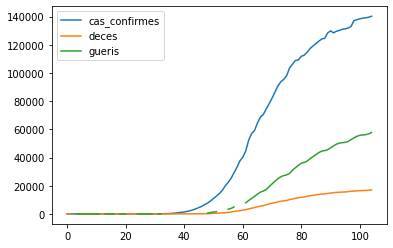

In [11]:
vplot.plot_CDG(evolution_par_jour)

Il y a encore des valeurs NAN dans la colonne des guéris, d'où les petits trous par endroits.

In [12]:
evolution_par_jour = cl.interpolate_nan(evolution_par_jour, "gueris")

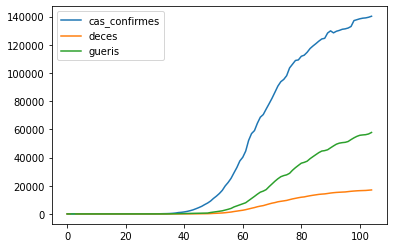

In [13]:
vplot.plot_CDG(evolution_par_jour)

### plot type model SIR

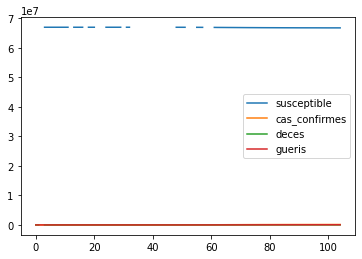

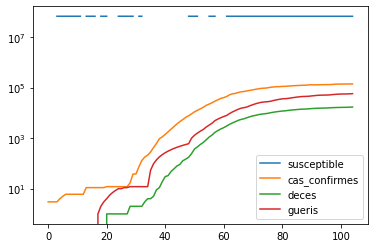

In [14]:
vplot.plot_SCDG(evolution_par_jour)
vplot.plot_SCDG(evolution_par_jour, logy=True)

La proportion de malades par rapport à la population totale est trop petite pour voir une évolution comme un modèle SIR classique.

## export csv

In [15]:
evolution_par_jour.to_csv("data/covid/france/evolution_par_jour.csv")